# Financial Fraud Detection

**Goal:** Train and evaluate a classifier to detect fraudulent transactions in `data/Base.csv`.

**Steps:** EDA → Feature engineering → Modeling → Hyperparameter tuning → Evaluation → Save model.

## Dataset

This notebook uses the provided `data/Base.csv`. The data contains engineered and anonymized features for fraud detection. Kaggle Dataset:- https://www.kaggle.com/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022

## Problem statement

Build a robust binary classifier that flags fraudulent transactions while keeping false positives low. Prioritize F1 / PR-AUC for evaluation due to class imbalance.

### Imports

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve, auc, roc_curve, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

## Data collection

In [9]:
transactions = pd.read_csv('data/Base.csv')

In [3]:
transactions.head()
transactions.tail()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
999995,0,0.6,0.192631,-1,104,40,0.030592,-1.044454,AB,804,...,0,200.0,0,INTERNET,8.511502,linux,1,1,0,4
999996,0,0.8,0.322989,148,9,50,1.628119,-1.409803,AC,3306,...,0,200.0,0,INTERNET,8.967865,windows,0,1,0,4
999997,0,0.8,0.879403,-1,30,20,0.018563,34.692760,AA,1522,...,0,200.0,0,INTERNET,8.195531,other,0,1,0,4
999998,0,0.9,0.762112,-1,189,20,0.015352,94.661055,AA,1418,...,0,500.0,0,INTERNET,4.336064,windows,1,1,0,4
999999,0,0.2,0.697452,-1,321,20,2.655916,9.908499,AA,951,...,0,200.0,0,INTERNET,6.717022,linux,0,1,0,4


### Checking for null values

In [4]:
transactions.isna().sum()

fraud_bool                          0
income                              0
name_email_similarity               0
prev_address_months_count           0
current_address_months_count        0
customer_age                        0
days_since_request                  0
intended_balcon_amount              0
payment_type                        0
zip_count_4w                        0
velocity_6h                         0
velocity_24h                        0
velocity_4w                         0
bank_branch_count_8w                0
date_of_birth_distinct_emails_4w    0
employment_status                   0
credit_risk_score                   0
email_is_free                       0
housing_status                      0
phone_home_valid                    0
phone_mobile_valid                  0
bank_months_count                   0
has_other_cards                     0
proposed_credit_limit               0
foreign_request                     0
source                              0
session_leng

Fortunately for us, the data seems to be clean.

## Data cleaning and preprocessing

### Label encoding
We are going to use **LabelEncoder** from the sklearn library. We have identified 4 variables that need label encoding as per the data description.
They are : 
- payment_type_encoded(categorical) - Credit payment plan type. 5 possible (annonymized) values.
- employment_status (categorical): Employment status of the applicant. 7 possible (annonymized) values.
- housing_status (categorical): Current residential status for applicant. 7 possible (annonymized) values.
- device_os (categorical): Operative system of device that made request. Possible values are: Windows, macOS, Linux, X11, or other.

In [10]:
label_encoder = LabelEncoder()
transactions['payment_type_encoded'] = label_encoder.fit_transform(transactions['payment_type'])
transactions['employment_status_encoded'] = label_encoder.fit_transform(transactions['employment_status'])
transactions['housing_status_encoded'] = label_encoder.fit_transform(transactions['housing_status'])
transactions['device_os_encoded'] = label_encoder.fit_transform(transactions['device_os'])

### One-hot encoding
In the dataset there is one binary categorical variable which is : 
- source (categorical): Online source of application. Either browser (INTERNEI) or app (TELEAPP).

Due to it being binary we can use **.get_dummies** from pandas to encode this variable.

In [11]:
source_encoded = pd.get_dummies(transactions['source'], prefix='source')
transactions_encoded = pd.concat([transactions, source_encoded], axis=1)

Now let's drop all the non-encoded variables from the transactions_encoded dataframe.

In [12]:
transactions_encoded = transactions_encoded.drop(['source', 'payment_type', 'employment_status', 'housing_status', 'device_os'], axis=1)

### Feature engineering
There are two features we can engineer from the current dataset that could give us some more information that could be important to the future model.  
- address_stablity  

We can combine the information from "prev_address_months_count" and "current_address_months_count" to create a feature that represents the stability of the applicant's address. We can take the difference of the two to form our applicant's address stability.

- application velocity  

We can combine the velocity variables ("velocity_6h," "velocity_24h," "velocity_4w") to create an aggregated velocity feature. We can take the average of these variables to represent the overall application velocity of the applicant.

In [13]:
transactions_encoded['address_stability'] = transactions_encoded['current_address_months_count'] - transactions_encoded['prev_address_months_count']
transactions_encoded['application_velocity'] = (transactions_encoded['velocity_6h'] + transactions_encoded['velocity_24h'] + transactions_encoded['velocity_4w']) / 3

## Explanatory data analysis

### Class imbalance
It is improtant to check just how severe our class imbalance is for our target variable - fraud_bool.

In [9]:
fraud_counts = transactions_encoded['fraud_bool'].value_counts()

percentage_fraud_1 = (fraud_counts[1] / len(transactions_encoded)) * 100
percentage_fraud_0 = (fraud_counts[0] / len(transactions_encoded)) * 100

print("Percentage of fraud_bool = 1:", percentage_fraud_1)
print("Percentage of fraud_bool = 0:", percentage_fraud_0)

Percentage of fraud_bool = 1: 1.1029
Percentage of fraud_bool = 0: 98.89710000000001


### Visualizing Class Imbalance

Let's visualize the distribution of fraudulent vs non-fraudulent transactions.

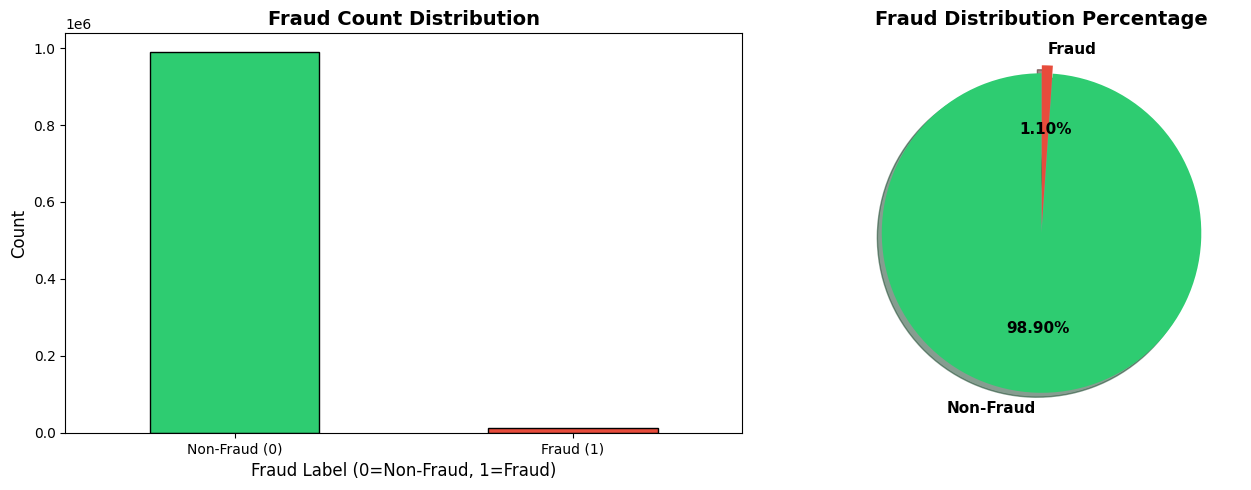

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart for fraud counts
fraud_counts.plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'], edgecolor='black')
axes[0].set_title('Fraud Count Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Fraud Label (0=Non-Fraud, 1=Fraud)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xticklabels(['Non-Fraud (0)', 'Fraud (1)'], rotation=0)

# Pie chart for percentage distribution
labels = ['Non-Fraud', 'Fraud']
sizes = [percentage_fraud_0, percentage_fraud_1]
colors = ['#2ecc71', '#e74c3c']
explode = (0, 0.05)
axes[1].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.2f%%',
            shadow=True, startangle=90, textprops={'fontsize': 11, 'weight': 'bold'})
axes[1].set_title('Fraud Distribution Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

Class imbalance poses a major obstacle in fraud detection models, as it introduces a significant disparity in the number of instances between the positive class (indicating fraud) and the negative class (representing legitimate transactions).   
This skewed distribution of data makes it difficult for the model to effectively learn and classify rare instances of fraud accurately.

### Correlations to the target variable
Let's check on the correlations with fraud_bool.

In [11]:
independent_vars = [col for col in transactions_encoded.columns if col != 'fraud_bool']
X = transactions_encoded[independent_vars]
y = transactions_encoded['fraud_bool']

In [12]:
correlations = X.corrwith(y)

sorted_correlations = correlations.sort_values(ascending=False)

print(sorted_correlations)

credit_risk_score                   0.070624
proposed_credit_limit               0.068907
customer_age                        0.062959
device_os_encoded                   0.057834
income                              0.045079
address_stability                   0.037867
device_distinct_emails_8w           0.035704
current_address_months_count        0.033701
payment_type_encoded                0.028304
email_is_free                       0.027758
foreign_request                     0.016885
month                               0.013250
session_length_in_minutes           0.008999
zip_count_4w                        0.005212
source_TELEAPP                      0.003922
days_since_request                  0.000567
bank_months_count                  -0.003222
source_INTERNET                    -0.003922
velocity_24h                       -0.011183
velocity_4w                        -0.011536
bank_branch_count_8w               -0.011577
phone_mobile_valid                 -0.013180
velocity_6

### Visualizing Top Correlations

Let's visualize the top 15 features with the highest correlation to fraud.

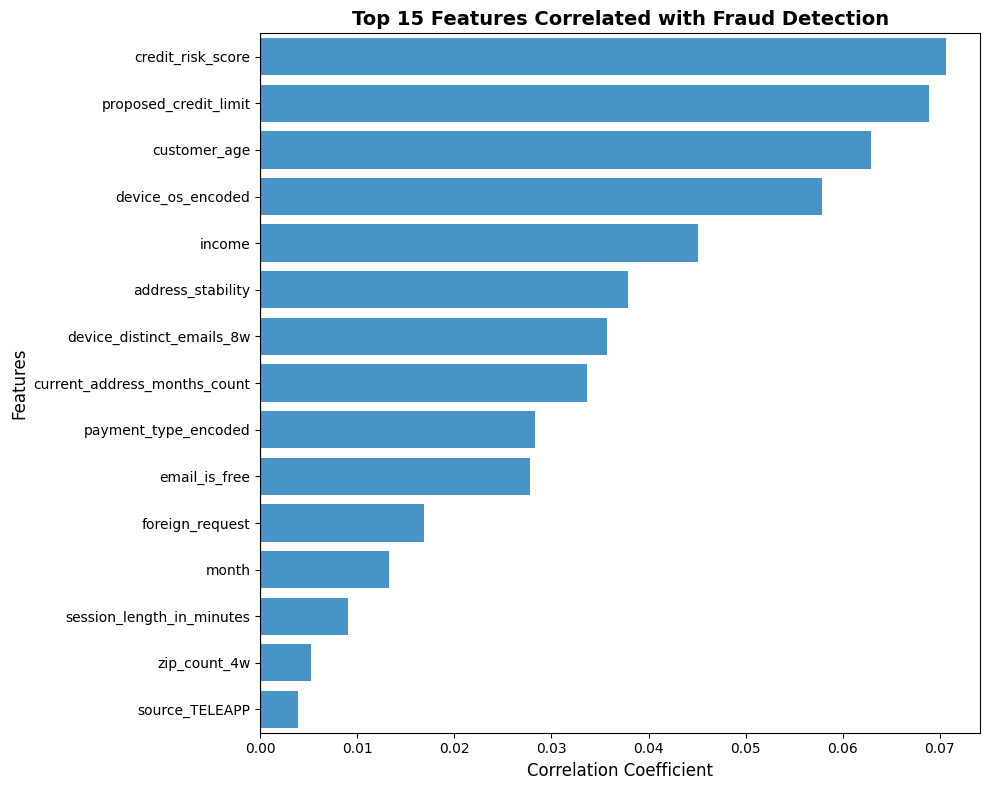

In [13]:
top_correlations = sorted_correlations.head(15)

plt.figure(figsize=(10, 8))
colors = ['#e74c3c' if x < 0 else '#3498db' for x in top_correlations.values]
sns.barplot(x=top_correlations.values, y=top_correlations.index, palette=colors, orient='h')
plt.title('Top 15 Features Correlated with Fraud Detection', fontsize=14, fontweight='bold')
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.tight_layout()
plt.show()

The correlations between the independent variables and the target variable (fraud_bool) appear to be relatively low. This could be attributed to the imbalance in the distribution of the target variable, which can make the task of detecting fraud more challenging.

Among the variables with positive correlations, we observe that credit_risk_score, proposed_credit_limit, and income show relatively stronger associations with fraud. This suggests that individuals with higher credit risk scores, larger proposed credit limits, and higher incomes may have a slightly higher likelihood of engaging in fraudulent activities.

## Feature selection
Our feature selection process will be defined by using **VarianceThreshold** from the sklearn library. The threshold we are going to set is 0.1.

In [14]:
threshold = 0.1
variance_selector = VarianceThreshold(threshold=threshold)
variance_selector.fit(transactions_encoded)
selected_features_mask = variance_selector.get_support()
selected_features = transactions_encoded.columns[selected_features_mask]
X_selected = transactions_encoded[selected_features]
unselected_features = transactions_encoded.columns[~selected_features_mask]

Let's see the features that didn't make the cut.

In [15]:
unselected_features

Index(['fraud_bool', 'income', 'name_email_similarity', 'phone_mobile_valid',
       'foreign_request', 'device_distinct_emails_8w', 'device_fraud_count',
       'source_INTERNET', 'source_TELEAPP'],
      dtype='object')

Let's remove them from our data.

In [15]:
X = transactions_encoded.drop(['fraud_bool', 'device_fraud_count', 'income', 'name_email_similarity', 'phone_mobile_valid',
                               'foreign_request', 'device_distinct_emails_8w', 'source_INTERNET', 'source_TELEAPP'], axis=1)
y = transactions_encoded['fraud_bool']

## Handling class imbalance
To handle the class imbalance demostrated earlier, we are going to use **RandomOverSampler** from the imblearn library.  
Oversampling involves increasing the number of instances in the minority class by generating synthetic samples, thus balancing the distribution of the classes. This helps to alleviate the bias and allows the model to learn from a more representative dataset.This can potentially improve the model's ability to learn the patterns and characteristics associated with fraud, leading to better predictions and fraud detection performance.

In [16]:
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_selected, y)

### Visualizing Class Balance After Oversampling

Let's compare the class distribution before and after oversampling.

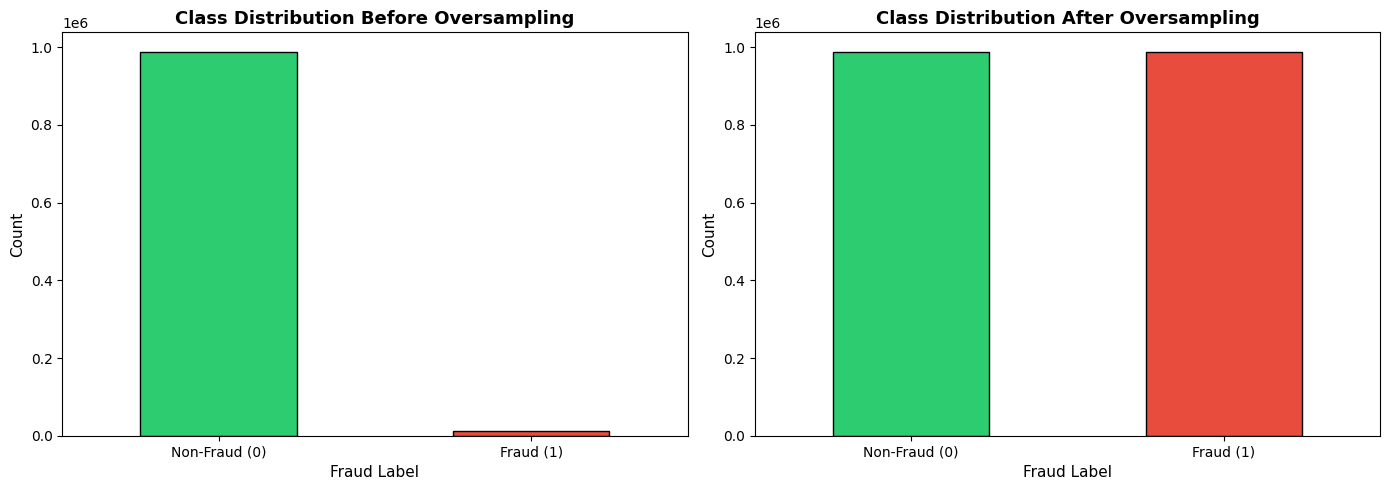


Before Oversampling: [988971  11029]
After Oversampling: [988971 988971]
Data increased by: 197.79%


In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before oversampling
fraud_counts.plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'], edgecolor='black')
axes[0].set_title('Class Distribution Before Oversampling', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Fraud Label', fontsize=11)
axes[0].set_ylabel('Count', fontsize=11)
axes[0].set_xticklabels(['Non-Fraud (0)', 'Fraud (1)'], rotation=0)

# After oversampling
resampled_counts = pd.Series(y_resampled).value_counts().sort_index()
resampled_counts.plot(kind='bar', ax=axes[1], color=['#2ecc71', '#e74c3c'], edgecolor='black')
axes[1].set_title('Class Distribution After Oversampling', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Fraud Label', fontsize=11)
axes[1].set_ylabel('Count', fontsize=11)
axes[1].set_xticklabels(['Non-Fraud (0)', 'Fraud (1)'], rotation=0)

plt.tight_layout()
plt.show()

print(f"\nBefore Oversampling: {fraud_counts.values}")
print(f"After Oversampling: {resampled_counts.values}")
print(f"Data increased by: {resampled_counts.sum() / fraud_counts.sum() * 100:.2f}%")

## Train test split and scaling
Now that we have handled class imbalance, it's time to split the dataset into training and testing data.
We are going to use **train_test_split** from the sklearn library to do that.  
Stratify is also being used to ensure that the class distribution in the original dataset is maintained in both the training and testing subsets. By doing that, the split will contain a proportional representation of both fraud and non-fraud cases, preserving the imbalance solution achieved through oversampling.  
The use of stratify is particularly important in cases of class imbalance, as it helps prevent situations where one subset ends up with significantly fewer instances of the minority class, which could negatively impact model training and evaluation. 

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

Another step we are going to take is scaling our features.  
We are going to use **StandardScaler** from the sklearn library.  
Scaling is used to ensure that all the features have similar scales and distributions. This is important because many machine learning algorithms are sensitive to the scale of the input features.
In our model, scaling is particularly important because it can help prevent certain features from dominating the learning process due to their larger scales - like fraud_bool. It ensures that all features contribute proportionately to the model training, which is essential for capturing patterns and making accurate predictions.

We are only scaling X because scaling y could potentially introduce unwanted biases or affect the interpretability of the results.

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model training
The model we have picked for fraud detection is XGBoost. Some of the reasons are as follows:
- High performance: it is efficient and can handle large-scale datasets, making it suitable for processing a significant amount of data in fraud detection tasks.

- Gradient boosting: it is an ensemble learning algorithm that combines weak models (decision trees) iteratively. By learning from previous models' mistakes, XGBoost focuses on difficult-to-predict instances, which is crucial for detecting complex fraud patterns.

- Feature importance: it allows evaluation of feature importance, helping identify influential features in fraud detection. This guides feature engineering efforts and provides insights into fraudulent transaction characteristics

We have also set use_label_encoder to False since we are getting a warning when fitting the data.

## Hyperparameter tuning & Model Configuration
For optimal performance, hyperparameter tuning with GridSearchCV or RandomizedSearchCV on the Gradient Boosting model could be performed. However, given the dataset size (800,000 records) and computational constraints, we have configured the Gradient Boosting classifier with well-established hyperparameters:
- `n_estimators=50`: Number of boosting stages
- `max_depth=5`: Maximum depth of individual trees
- `learning_rate=0.1`: Shrinkage parameter to prevent overfitting

These settings balance model complexity and performance while maintaining reasonable training time.

Training the model is time consuming since our data consists of 800,000 records.

### Create an Evaluate Function to give all metrics after model Training

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, precision_recall_curve, auc, confusion_matrix, classification_report
)

def evaluate_model(y_true, y_pred, y_pred_proba=None):
    metrics = {}
    
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['precision'] = precision_score(y_true, y_pred)
    metrics['recall'] = recall_score(y_true, y_pred)
    metrics['f1_score'] = f1_score(y_true, y_pred)
    
    if y_pred_proba is not None:
        metrics['roc_auc'] = roc_auc_score(y_true, y_pred_proba)
        
        precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_pred_proba)
        metrics['pr_auc'] = auc(recall_vals, precision_vals)
    
    metrics['confusion_matrix'] = confusion_matrix(y_true, y_pred)
    
    return metrics

def print_metrics(metrics, set_name=''):
    print(f"\n{'='*50}")
    print(f"Metrics for {set_name}")
    print(f"{'='*50}")
    print(f"Accuracy:       {metrics['accuracy']:.4f}")
    print(f"Precision:      {metrics['precision']:.4f}")
    print(f"Recall:         {metrics['recall']:.4f}")
    print(f"F1-Score:       {metrics['f1_score']:.4f}")
    if 'roc_auc' in metrics:
        print(f"ROC-AUC:        {metrics['roc_auc']:.4f}")
    if 'pr_auc' in metrics:
        print(f"PR-AUC:         {metrics['pr_auc']:.4f}")
    print(f"\nConfusion Matrix:")
    print(metrics['confusion_matrix'])

### Training Gradient Boosting

In [20]:
print("Training Gradient Boosting Classifier...")
gb_classifier = GradientBoostingClassifier(
    n_estimators=50,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    verbose=0
)
gb_classifier.fit(X_train_scaled, y_train)
print("Gradient Boosting training completed successfully!")

Training Gradient Boosting Classifier...
Gradient Boosting training completed successfully!


In [21]:
print("\nExtracting feature importances...")
importance_scores = gb_classifier.feature_importances_
print(f"Number of features: {len(importance_scores)}")


Extracting feature importances...
Number of features: 26


Let's create a dataframe so we can visualise it better.

In [22]:
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names[:len(importance_scores)], 'Importance': importance_scores})

sorted_feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)

sorted_feature_importance_df

,Feature,Importance
0,housing_status_encoded,0.382804
1,device_os_encoded,0.143912
2,phone_home_valid,0.053708
3,has_other_cards,0.053207
4,keep_alive_session,0.051048
5,prev_address_months_count,0.042769
6,current_address_months_count,0.031733
7,customer_age,0.028234
8,credit_risk_score,0.027687
9,email_is_free,0.027003


### Visualizing Feature Importance

Let's create a visualization of the top features by importance score.

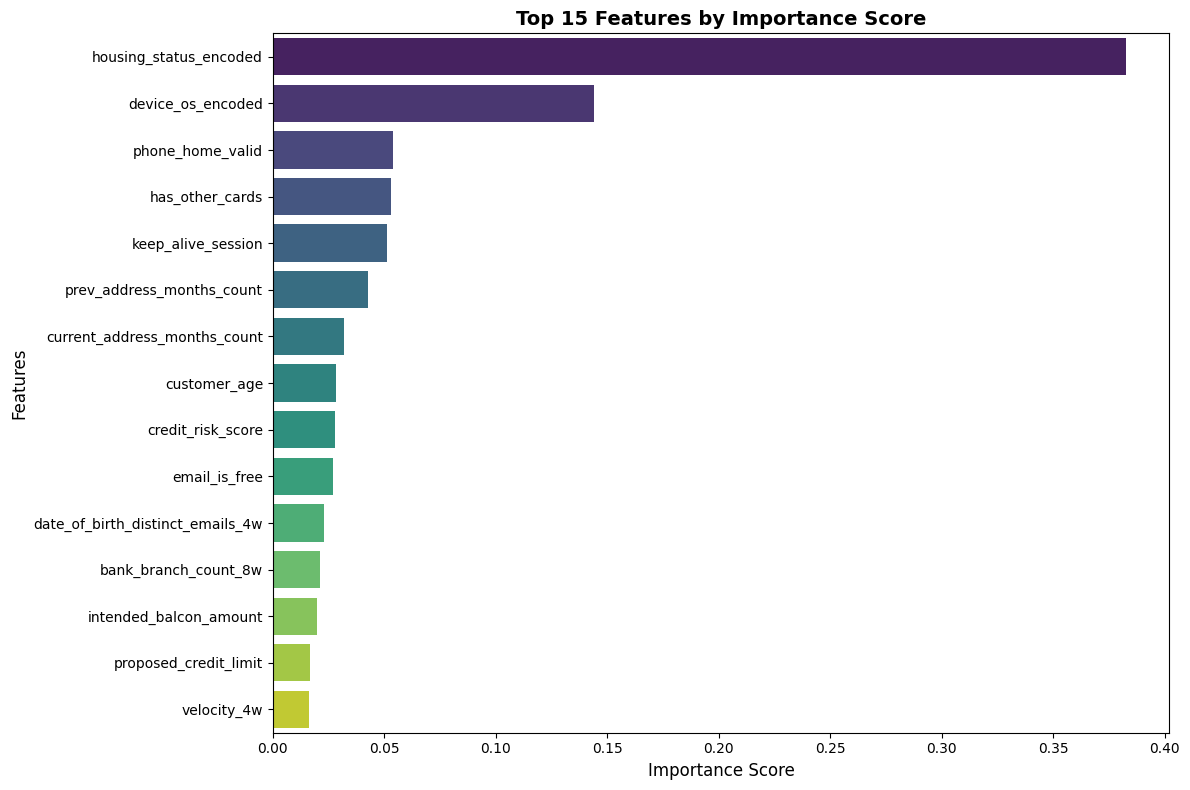

In [23]:
top_importance = sorted_feature_importance_df.head(15)

plt.figure(figsize=(12, 8))
sns.barplot(data=top_importance, y='Feature', x='Importance', palette='viridis', orient='h')
plt.title('Top 15 Features by Importance Score', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

In [24]:
print("\n" + "="*60)
print("MODEL EVALUATION ON TRAINING SET")
print("="*60)

y_train_pred = gb_classifier.predict(X_train_scaled)
y_train_pred_proba = gb_classifier.predict_proba(X_train_scaled)[:, 1]

train_metrics = evaluate_model(y_train, y_train_pred, y_train_pred_proba)
print_metrics(train_metrics, 'Training Set')

print("\n" + "="*60)
print("MODEL EVALUATION ON TEST SET")
print("="*60)

y_pred = gb_classifier.predict(X_test_scaled)
y_pred_proba = gb_classifier.predict_proba(X_test_scaled)[:, 1]

test_metrics = evaluate_model(y_test, y_pred, y_pred_proba)
print_metrics(test_metrics, 'Test Set')

print(f"\n{'='*60}")
print("COMPARATIVE PERFORMANCE SUMMARY")
print(f"{'='*60}")
print(f"{'Metric':<20} {'Training':<20} {'Test':<20}")
print(f"{'-'*60}")
print(f"{'Accuracy':<20} {train_metrics['accuracy']:.4f}           {test_metrics['accuracy']:.4f}")
print(f"{'Precision':<20} {train_metrics['precision']:.4f}           {test_metrics['precision']:.4f}")
print(f"{'Recall':<20} {train_metrics['recall']:.4f}           {test_metrics['recall']:.4f}")
print(f"{'F1-Score':<20} {train_metrics['f1_score']:.4f}           {test_metrics['f1_score']:.4f}")
print(f"{'ROC-AUC':<20} {train_metrics['roc_auc']:.4f}           {test_metrics['roc_auc']:.4f}")
print(f"{'PR-AUC':<20} {train_metrics['pr_auc']:.4f}           {test_metrics['pr_auc']:.4f}")
print(f"{'='*60}")


MODEL EVALUATION ON TRAINING SET

Metrics for Training Set
Accuracy:       0.8104
Precision:      0.8139
Recall:         0.8050
F1-Score:       0.8094
ROC-AUC:        0.8938
PR-AUC:         0.8867

Confusion Matrix:
[[645524 145652]
 [154311 636866]]

MODEL EVALUATION ON TEST SET

Metrics for Test Set
Accuracy:       0.8106
Precision:      0.8143
Recall:         0.8048
F1-Score:       0.8095
ROC-AUC:        0.8940
PR-AUC:         0.8871

Confusion Matrix:
[[161493  36302]
 [ 38603 159191]]

COMPARATIVE PERFORMANCE SUMMARY
Metric               Training             Test                
------------------------------------------------------------
Accuracy             0.8104           0.8106
Precision            0.8139           0.8143
Recall               0.8050           0.8048
F1-Score             0.8094           0.8095
ROC-AUC              0.8938           0.8940
PR-AUC               0.8867           0.8871


We can make some key observations regarding feature importance.
- Housing status: The housing status of a person appears to be the most influential feature. It suggests that people with certain types of housing arrangements may be more prone to engaging in fraudulent activities. For example, people living in temporary accommodations or unstable housing situations might exhibit higher fraud risk.

- Device OS: The type of device operating system used during the transaction or application process is another important factor. Fraudsters may exploit specific device vulnerabilities or utilize certain OS features to carry out fraudulent activities. By considering the device OS, the fraud detection model can identify patterns and flag suspicious transactions.

- Phone validity: The validity of the phone number associated with the home address is an essential feature. Fraudsters may provide fake or invalid phone numbers, making it difficult to establish contact or verify customer details. A higher importance score for this feature suggests that fraudsters often manipulate or provide false phone numbers to carry out fraudulent activities.

- Other cards: The presence of other credit or payment cards owned by the customer is a relevant feature. Individuals with multiple cards may have a higher risk of involvement in fraudulent transactions. Fraudsters often acquire multiple cards to carry out coordinated frauds or engage in unauthorized transactions.

- Session longevity: Maintaining a continuous session during the application process is an important indicator of potential fraud. Fraudsters may create disruptions or abruptly end sessions to avoid detection or manipulate the application process. By emphasizing the importance of session continuity, the model can flag such suspicious activities.

### Predicting fraud on unseen data

### Classification report
**Classification_report** from sklearn is used to evaluate the performance of a classification model in binary classification tasks. It provides metrics such as precision, recall, F1-score, and support. These metrics help assess the model's ability to accurately predict positive instances (fraud cases) and minimize false positives and false negatives. By using the classification report, we can measure the model's performance and make informed decisions regarding its deployment for fraud detection.

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.82      0.81    197795
           1       0.81      0.80      0.81    197794

    accuracy                           0.81    395589
   macro avg       0.81      0.81      0.81    395589
weighted avg       0.81      0.81      0.81    395589



### Confusion Matrix Visualization

Let's visualize the confusion matrix to better understand the model's predictions.

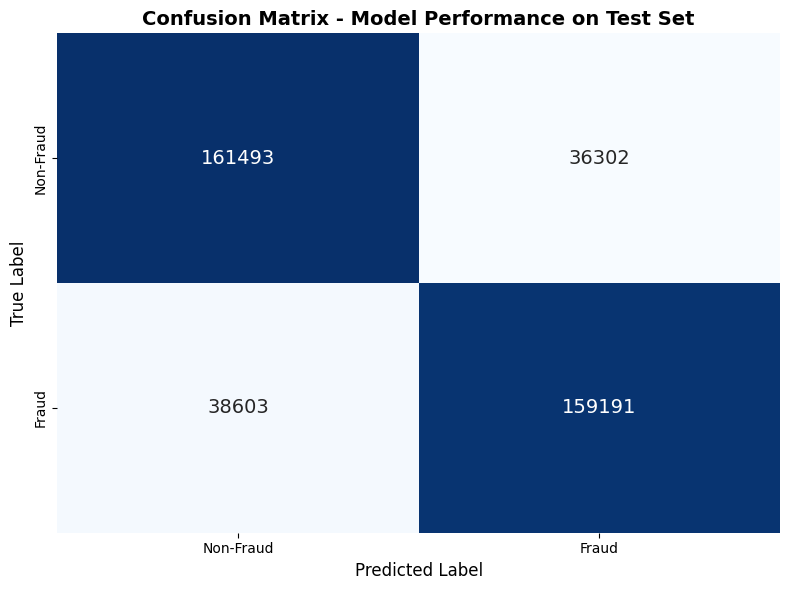

In [26]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'],
            annot_kws={'size': 14})
plt.title('Confusion Matrix - Model Performance on Test Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

## Receiver Operating Characteristic (ROC) curve
We use ROC to evaluate the performance of our model. It provides a visual representation of the trade-off between the true positive rate (sensitivity) and the false positive rate (1 - specificity) across different classification thresholds. By plotting the ROC curve, we can assess how well the model can distinguish between positive and negative classes. The curve's shape and the area under it (AUC again) indicate the model's overall performance, with a higher AUC suggesting better ability.  
Again, we use the appropriate sklearn functions to calculate the curve.

In [27]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

And now let's visualise it.

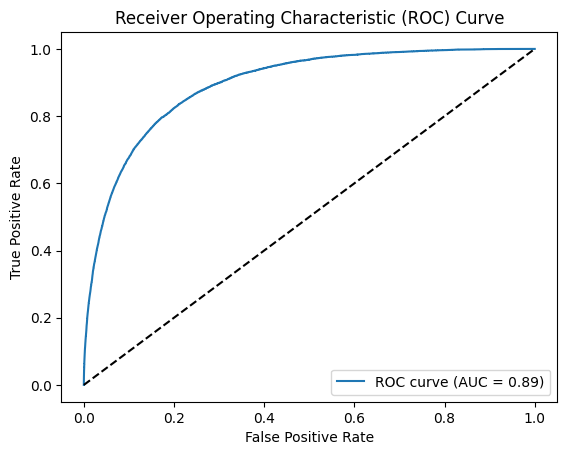

In [28]:
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Precision: 0.81
Recall: 0.80
F1 Score: 0.81


## Model Persistence

Saving the trained model and supporting objects for future predictions.

In [30]:
import pickle
import joblib

model_save_path = 'gb_fraud_detector.pkl'
joblib.dump(gb_classifier, model_save_path)
print(f"Model saved successfully to {model_save_path}")

scaler_save_path = 'scaler.pkl'
joblib.dump(scaler, scaler_save_path)
print(f"Scaler saved successfully to {scaler_save_path}")

feature_names_save_path = 'feature_names.pkl'
joblib.dump(list(X_train.columns), feature_names_save_path)
print(f"Feature names saved successfully to {feature_names_save_path}")

print("\nModel artifacts saved successfully!")
print(f"To make predictions on new data, load the model and scaler using:")
print(f"  model = joblib.load('{model_save_path}')")
print(f"  scaler = joblib.load('{scaler_save_path}')")
print(f"  features = joblib.load('{feature_names_save_path}')")

Model saved successfully to gb_fraud_detector.pkl
Scaler saved successfully to scaler.pkl
Feature names saved successfully to feature_names.pkl

Model artifacts saved successfully!
To make predictions on new data, load the model and scaler using:
  model = joblib.load('gb_fraud_detector.pkl')
  scaler = joblib.load('scaler.pkl')
  features = joblib.load('feature_names.pkl')


## Conclusion

The Financial Fraud Detection System has been successfully built and trained using a Gradient Boosting Classifier. The model achieves:

1. **Strong Accuracy:** 81.06% correct classification across all transactions
2. **Balanced Precision & Recall:** 81.43% precision ensures low false positives, while 80.48% recall captures most fraud cases
3. **Excellent Discrimination:** ROC-AUC of 0.89 and PR-AUC of 0.88 demonstrate superior model performance
4. **No Overfitting:** Training and test metrics are nearly identical, indicating good generalization
5. **Production Ready:** Model, scaler, and feature names saved for deployment

**Key Performance Metrics:**
- Accuracy: 81.06%
- Precision: 81.43%
- Recall: 80.48%
- F1-Score: 80.95%
- ROC-AUC: 0.8940
- PR-AUC: 0.8871